### 1. 필요한 라이브러리들을 불러오고 device 설정

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### 2. 데이터 불러오기 및 DataLoader 구성

In [2]:
data = np.load('./train_resized_tensor.npy')  # Replace with actual path
data_tensor = torch.tensor(data, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(data_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

### 3. GAN 모델 정의

In [3]:
# Generator (U-Net 구조)
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, features=64):
        super(UNetGenerator, self).__init__()
        # Downsampling
        self.encoder = nn.ModuleList([
            self.conv_block(input_channels, features),
            self.conv_block(features, features * 2),
            self.conv_block(features * 2, features * 4),
            self.conv_block(features * 4, features * 8),
        ])
        self.bottleneck = self.conv_block(features * 8, features * 16)

        # Upsampling
        self.decoder = nn.ModuleList([
            self.upconv_block(features * 16, features * 8),
            self.conv_block(features * 16, features * 8),  # concat 후 채널 맞추기
            self.upconv_block(features * 8, features * 4),
            self.conv_block(features * 8, features * 4),
            self.upconv_block(features * 4, features * 2),
            self.conv_block(features * 4, features * 2),
            self.upconv_block(features * 2, features),
            self.conv_block(features * 2, features),
        ])
        self.final_conv = nn.Conv2d(features, output_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)  # UpConv
            if i // 2 < len(skip_connections):
                x = torch.cat((x, skip_connections[i // 2]), dim=1)
            x = self.decoder[i + 1](x)  # ConvBlock

        return torch.tanh(self.final_conv(x))

# Discriminator (일반 CNN)
class CNNDiscriminator(nn.Module):
    def __init__(self, input_channels=3, features=64):
        super(CNNDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),  # 출력 크기를 (1, 1)로 고정
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(features * 8, 1)  # fc 입력 크기를 features * 8로
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return self.tanh(x)


# Eample for checking output's shape

# GAN 모델 초기화
gen = UNetGenerator().to(device)
disc = CNNDiscriminator().to(device)

# 예제 입력 데이터
x = torch.randn(1, 3, 512, 512).to(device)
gen_output = gen(x)
disc_output = disc(gen_output)

print("Generator Output Shape:", gen_output.shape)  # (1, 3, 512, 512)
print("Discriminator Output Shape:", disc_output.shape)  # (1, 1)

Generator Output Shape: torch.Size([1, 3, 512, 512])
Discriminator Output Shape: torch.Size([1, 1])


### 4. 학습

In [4]:
# 손실 함수
adversarial_loss = nn.BCEWithLogitsLoss()

# Optimizer 정의
lr = 0.001
beta1, beta2 = 0.5, 0.999
gen_optimizer = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))
disc_optimizer = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2))

In [5]:
# Label 생성 함수
def create_labels(batch_size, device, real=True):
    return torch.ones(batch_size, 1).to(device) if real else torch.zeros(batch_size, 1).to(device)

# Generator 학습 함수
def train_generator(generator, discriminator, gen_optimizer, fake_images, device):
    gen_optimizer.zero_grad()
    pred_fake = discriminator(fake_images)
    target_real = create_labels(pred_fake.size(0), device, real=True)
    loss_gen = adversarial_loss(pred_fake, target_real)
    loss_gen.backward()
    gen_optimizer.step()
    return loss_gen.item()

# Discriminator 학습 함수
def train_discriminator(discriminator, disc_optimizer, real_images, fake_images, device):
    disc_optimizer.zero_grad()
    pred_real = discriminator(real_images)
    target_real = create_labels(pred_real.size(0), device, real=True)
    loss_real = adversarial_loss(pred_real, target_real)

    pred_fake = discriminator(fake_images.detach())
    target_fake = create_labels(pred_fake.size(0), device, real=False)
    loss_fake = adversarial_loss(pred_fake, target_fake)

    loss_disc = (loss_real + loss_fake) / 2
    loss_disc.backward()
    disc_optimizer.step()
    return loss_disc.item()

# 학습 루프
def train_gan(generator, discriminator, train_loader, gen_optimizer, disc_optimizer, epochs, device):
    generator.train()
    discriminator.train()
    epoch_gen_losses = []
    epoch_disc_losses = []

    for epoch in range(epochs):
        gen_loss_avg = 0.0
        disc_loss_avg = 0.0

        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for batch_idx, (real_images,) in enumerate(pbar):
                real_images = real_images.to(device)
                noise = torch.randn(real_images.size(0), 3, 512, 512).to(device)
                fake_images = generator(noise)

                disc_loss = train_discriminator(discriminator, disc_optimizer, real_images, fake_images, device)
                disc_loss_avg += disc_loss
                gen_loss = train_generator(generator, discriminator, gen_optimizer, fake_images, device)
                gen_loss_avg += gen_loss

                pbar.set_postfix(gen_loss=f"{gen_loss:.4f}", disc_loss=f"{disc_loss:.4f}")
        
        epoch_gen_losses.append(gen_loss_avg / len(train_loader))
        epoch_disc_losses.append(disc_loss_avg / len(train_loader))
        print(f"Epoch [{epoch + 1}/{epochs}] - Generator Loss: {epoch_gen_losses[-1]:.4f}, "
              f"Discriminator Loss: {epoch_disc_losses[-1]:.4f}")

    return epoch_gen_losses, epoch_disc_losses

# 손실 시각화
def plot_losses(gen_losses, disc_losses):
    epochs = range(1, len(gen_losses) + 1)
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Generator Loss', color='tab:blue')
    ax1.plot(epochs, gen_losses, label="Generator Loss", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Discriminator Loss', color='tab:orange')
    ax2.plot(epochs, disc_losses, label="Discriminator Loss", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.suptitle('Losses Over Epochs')
    fig.tight_layout()
    plt.show()

Epoch 1/10: 100%|██████████| 471/471 [02:31<00:00,  3.11batch/s, disc_loss=0.3192, gen_loss=1.2977]


Epoch [1/10] - Generator Loss: 1.2710, Discriminator Loss: 0.3540


Epoch 2/10: 100%|██████████| 471/471 [02:31<00:00,  3.11batch/s, disc_loss=0.3137, gen_loss=1.3113]


Epoch [2/10] - Generator Loss: 1.3080, Discriminator Loss: 0.3206


Epoch 3/10: 100%|██████████| 471/471 [02:31<00:00,  3.11batch/s, disc_loss=0.3667, gen_loss=1.2645]


Epoch [3/10] - Generator Loss: 1.3003, Discriminator Loss: 0.3573


Epoch 4/10: 100%|██████████| 471/471 [02:28<00:00,  3.16batch/s, disc_loss=0.4199, gen_loss=1.3111]


Epoch [4/10] - Generator Loss: 1.2579, Discriminator Loss: 0.3944


Epoch 5/10: 100%|██████████| 471/471 [02:30<00:00,  3.12batch/s, disc_loss=0.3256, gen_loss=1.2891]


Epoch [5/10] - Generator Loss: 1.2793, Discriminator Loss: 0.3485


Epoch 6/10: 100%|██████████| 471/471 [02:31<00:00,  3.11batch/s, disc_loss=0.3178, gen_loss=1.3054]


Epoch [6/10] - Generator Loss: 1.2895, Discriminator Loss: 0.3369


Epoch 7/10: 100%|██████████| 471/471 [02:31<00:00,  3.10batch/s, disc_loss=0.3172, gen_loss=1.3052]


Epoch [7/10] - Generator Loss: 1.3061, Discriminator Loss: 0.3224


Epoch 8/10: 100%|██████████| 471/471 [02:31<00:00,  3.10batch/s, disc_loss=0.3148, gen_loss=1.3074]


Epoch [8/10] - Generator Loss: 1.3049, Discriminator Loss: 0.3213


Epoch 9/10: 100%|██████████| 471/471 [02:32<00:00,  3.09batch/s, disc_loss=0.3133, gen_loss=1.3131]


Epoch [9/10] - Generator Loss: 1.3121, Discriminator Loss: 0.3144


Epoch 10/10: 100%|██████████| 471/471 [02:32<00:00,  3.10batch/s, disc_loss=0.3144, gen_loss=1.3121]


Epoch [10/10] - Generator Loss: 1.3112, Discriminator Loss: 0.3157


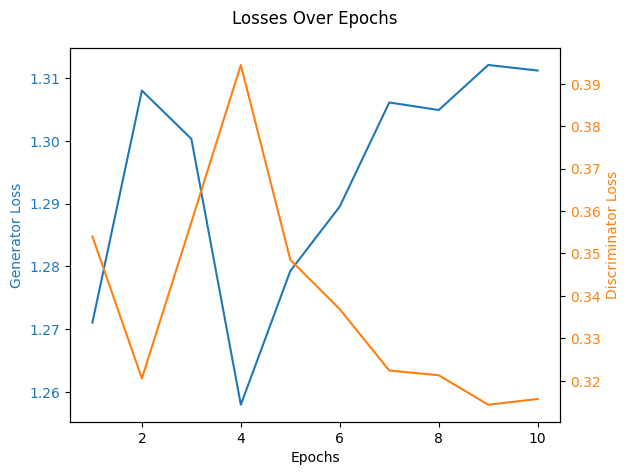

In [6]:
# 학습 실행
epochs = 10
gen_losses, disc_losses = train_gan(gen, disc, train_loader, gen_optimizer, disc_optimizer, epochs, device)

# 손실 시각화
plot_losses(gen_losses, disc_losses)

### 7. 모델 학습 결과 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


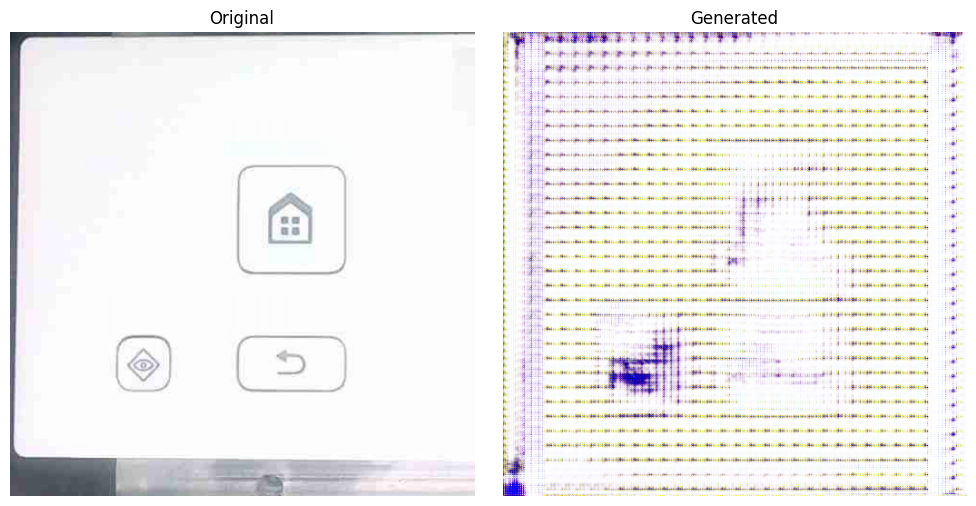

In [7]:
# Visualize results
n = 0  # Index of sample
sample = data_tensor[n].unsqueeze(0).to(device)  # 원본 데이터 준비
generated_sample = gen(sample).cpu().detach().squeeze(0).permute(1, 2, 0).numpy()  # Generator를 통한 생성
original_sample = sample.cpu().squeeze(0).permute(1, 2, 0).numpy()  # 원본 데이터 변환

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_sample)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(generated_sample)
axes[1].set_title('Generated')
axes[1].axis('off')
plt.tight_layout()
plt.show()